# Tarea final: Google Data Analytics

Caso de estudio: **Cyclistic**
Cyclistic es una empresa **ficticia** que opera un sistema de bicicletas compartidas en Chicago, con más de 5.000 bicicletas y 600 estaciones. Los usuarios pueden alquilar bicicletas en una estación y dejarlas en otra dentro de la ciudad.
Existen dos tipos de usuarios:
Casuales, que alquilan por viaje.


Miembros, que acceden al sistema mediante una suscripción anual.


Para realizar este proyecto se seguiran las faces del análisis descritas en el curso de Google Data Analytics

1. ASK
2. PREPARE
3. PROCESS
4. ANALYZE
5. SHARE
6. ACT

# Fase: Ask
**Problema a resolver**
Determinar qué diferencias existen entre los usuarios casuales y los miembros, con el fin de comprender qué podría motivar a los casuales a convertirse en miembros.

**Pregunta guía**
¿En qué se diferencia el comportamiento de viaje entre los usuarios casuales y los miembros?

**Objetivo del análisis**
Identificar patrones en los datos que permitan generar recomendaciones de marketing efectivas para incrementar el número de miembros.

**Tarea empresarial**
Analizar los registros de viajes de los últimos 12 meses para detectar diferencias clave en el comportamiento de ambos tipos de usuarios, que puedan orientar una estrategia para convertir usuarios casuales en suscriptores.

**Stakeholders**

* Equipo ejecutivo de Cyclistic
* Directora de Marketing: Lily Moreno


# Fase: Prepare

**Problema a resolver**

Verificar que los datos cumplen con el estándar ROCCC, es decir, que sean:

Reliable (Fiables), Original (Originales), Comprehensive (Completos), Current (Actuales) y Cited (Citados)

**Datos usados**
Período: junio 2024 – junio 2025
Total de viajes registrados: 5.628.847
Formato: .csv
Fuente: Motivate International Inc. (operadora de Divvy)
Licencia: Datos abiertos, anonimizados, sin información personal identificable

**Estructura de datos**

Cada fila representa un viaje e incluye:


* ride_id: Identificador único recorrido realizado
* rideable_type: Tipo de vehículo (bicicleta clásica, bicicleta eléctrica o scooter eléctrico)
* started_at y ended_at: Fecha y hora en las que inicia y finaliza el recorrido
* start_station_name / start_station_id	: Nombre e ID de estación
* inicial end_station_name / end_station_id: Nombre e ID de la estación final
* start_lat / start_lng: Coordenadas geográficas de inicio
* end_lat / end_lng: Coordenadas geográficas finales
* member_casual: Tipo de usuario, puedes ser miembro o casual

**Consideraciones éticas:**
Los datos están anonimizados y no contienen información personal.

Cumplen con las políticas de privacidad y uso de datos del proveedor.


**Verificación de calidad:**
Se revisó la integridad de los datos usando herramientas de R:

Valores nulos:
29.7% de los registros no tienen estación de inicio → Se separaron para análisis opcional

IDs duplicados: No se encontraron

Tipos de vehículo: 3 tipos válidos (classic, electric, scooter)


Usuarios: Solo "member" y "casual"


Fechas inválidas / viajes negativos: Eliminados

# Fase: Process

**Herramientas utilizadas**
Para el análisis, transformación y limpieza de los datos se utilizó R, un lenguaje de programación especializado en análisis estadístico y visualización de datos.

**Entorno de trabajo: RStudio (Visual Studio + complemento de R)**

Librerías clave:


* tidyverse para manipulación y limpieza de datos
* lubridate para el manejo de fechas
* ggplot2 para visualización
* dplyr para filtrado y agrupación de datos
* scales para mejorar la presentación de gráficos


El uso de R permitió trabajar con grandes volúmenes de datos, automatizar tareas de validación y generar visualizaciones útiles para el análisis.

**Integridad de Datos**

Para asegurar que los datos sean fiables y útiles para el análisis, se realizaron varios pasos de limpieza y validación:


El primer paso será cargar la base de datos

In [5]:
library(tidyverse)

Ahora agregamos el dataset anualD
Este reune un año de viajes en un solo archivo

In [7]:
anualD <- read_csv("/kaggle/input/datos-originales/anualD.csv")

Rows: 5628847 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ride_id, rideable_type, start_station_name, start_station_id, end_...
dbl  (4): start_lat, start_lng, end_lat, end_lng
dttm (2): started_at, ended_at

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pasos a seguir
1. Primeras verificaciones:

* Que los ID de viaje (ride_id) fueran únicos
* Que existieran solo los tres tipos válidos de vehículos: classic_bike, electric_bike, y scooter.
* Que los usuarios solo estuvieran clasificados como casual o member

In [17]:
# Verificar ID
sapply(anualD,n_distinct) #Contará lso datos distíntios de todas las entrada
nrow(anualD) # Nos dará el numero total de entradas en el dataset

# Con esto comprobamos que el número de ride_id unicos son iguales a el número total de entrada
# Por lo que no hay repeticiones en los ID

# También vemos que los rideable_type son solo 3 (classic_bike, electric_bike, y scooter)
# Y que solo hay 2 tipos de miembros (Casuales o miembros)

ride_id      rideable_type         started_at           ended_at 
           5628847                  3            5627717            5626976 
start_station_name   start_station_id   end_station_name     end_station_id 
              1870               1786               1873               1788 
         start_lat          start_lng            end_lat            end_lng 
            290588             281548               2754               2776 
     member_casual   duracion_minutos 
                 2            2571229

[1] 5628847

2. Cálculo de duración de viajes

Crearemos una nueva columna *duracion_minutos* para calcular la duración del viaje.


In [18]:
anualD <- anualD %>%
    mutate(duracion_minutos = as.numeric(difftime(ended_at, started_at, units = "mins")))


summary(anualD$duracion_minutos) #Así podemos ver un resumen de la duración de los viajes

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -56.022    5.441    9.519   16.628   16.833 1559.918 

Podemso ver que existen viajes *negativos* y de hasta *25horas*
Consideramos que esos son erorres en la base de datos y procederemos a eliminar esos registros

Pra realizar una limpieza profunda según la duración de los viajes
Vamos a: 

1. Eliminar viajes negativos
2. Eliminar viajes menores de 1 min o de más de 90 min para tener

In [19]:
# PASO 1: ELIMINAR NEGATIVOS

anualD <- anualD %>%
        filter(duracion_minutos >= 1)

# PASO 2: AJUSATAR DURACION DE VIAJES ENTRE 1 MIN Y 90 MIN

anualD <- anualD %>%
  filter(duracion_minutos >= 1, duracion_minutos <= 90)

summary(anualD$duracion_minutos)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.635   9.625  13.462  16.695  90.000 

Lo ultimo es eliminar los registros que están incompletos

Primero comprobar lo que da problemas

In [20]:
colSums(is.na(anualD))

ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
           1003809            1003809            1004558            1004558 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0                  5                  5 
     member_casual   duracion_minutos 
                 0                  0

Así podemos ver todos los registros en blanco sobretodo en estaciones de inicio y estraciones finales de cada viaje.

No es totalmente necesario para el analisis en este caso, pero se tomó la desición de solo trabajar con los datos entreros, por lo que vamos a eliminar el resto

In [22]:
anualD <- anualD %>%
  filter(!is.na(start_station_name), !is.na(end_station_name))

colSums(is.na(anualD)) # Comprobación final

ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
                 0                  0                  0                  0 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0                  0                  0 
     member_casual   duracion_minutos 
                 0                  0

# Fase: Analize

Aplicaremos métodos de análisis descriptivo, incluyendo:

* Comparación de miembros y usuarios casuales
* Cálculo de medidas de tendencia central y dispersión en la duración de viajes.
* Comparación de patrones de uso por tipo de usuario (casual vs member)
* Análisis de comportamiento según hora del día, día de la semana y mes.
* Visualización de resultados en gráficos de barras y distribuciones comparativas.


In [36]:
# Proporción miembros vs casuales

mix_usuarios <- anualD %>%
  group_by(member_casual) %>%
  summarise(conteo = n()) %>%
  mutate(porcentaje = round(conteo / sum(conteo) * 100, 1))
mix_usuarios

member_casual,conteo,porcentaje
<chr>,<int>,<dbl>
casual,1386876,35.7
member,2497661,64.3


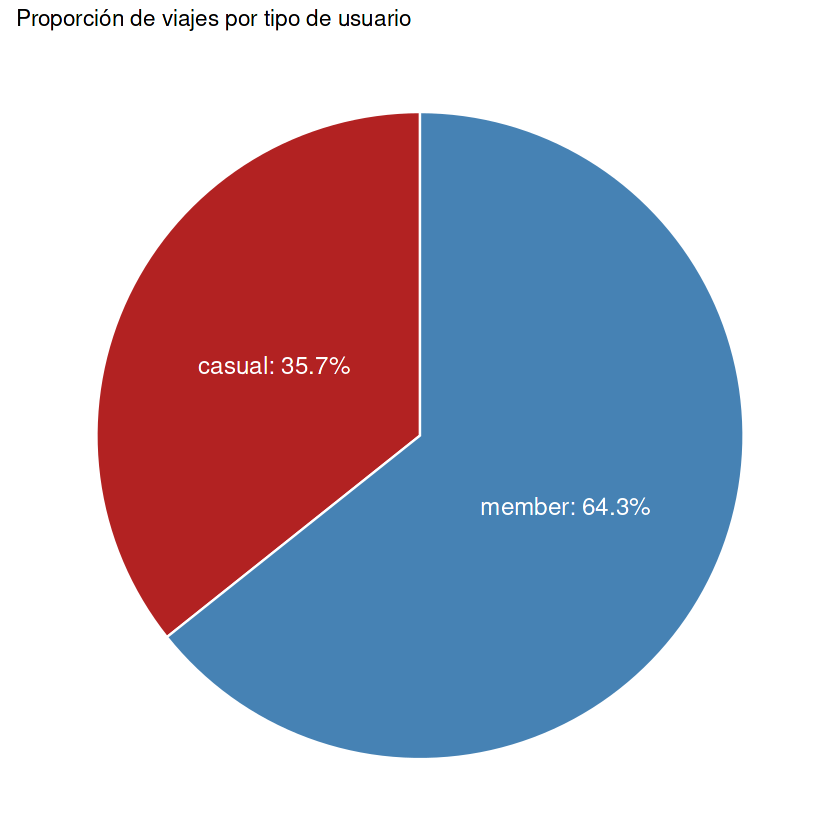

In [37]:
mix_usuarios %>%
  mutate(etiqueta = paste0(member_casual, ": ", porcentaje, "%")) %>%
  ggplot(aes(x = "", y = conteo, fill = member_casual)) +
  geom_col(width = 1, color = "white") +
  coord_polar(theta = "y") +
  geom_text(aes(label = etiqueta), position = position_stack(vjust = 0.5),
            color = "white", size = 5) +
  labs(title = "Proporción de viajes por tipo de usuario") +
  scale_fill_manual(values = c("casual"="firebrick","member"="steelblue")) +
  theme_void() + theme(legend.position = "none")

In [25]:
#Para facilitar el anális, vamos a agregar hora de inicio, mes y dia de la semana

anualD <- anualD %>%
  mutate(
    hora_inicio = hour(started_at),
    dia_semana  = wday(started_at, label = TRUE, abbr = TRUE, week_start = 1), # Lu a Do
    mes         = month(started_at, label = TRUE, abbr = TRUE)
  )

In [27]:
# 1 Duración global
summary(anualD$duracion_minutos)

# 2 Duración por tipo de usuario
anualD %>%
  group_by(member_casual) %>%
  summarise(
    promedio = mean(duracion_minutos),
    mediana  = median(duracion_minutos),
    maximo   = max(duracion_minutos),
    minimo   = min(duracion_minutos),
    conteo   = n()
  )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.781   9.906  14.064  17.427  90.000 

member_casual,promedio,mediana,maximo,minimo,conteo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
casual,18.33691,12.754850,89.99973,1.000933,1386876
member,11.69155,8.713283,89.99845,1.000000,2497661


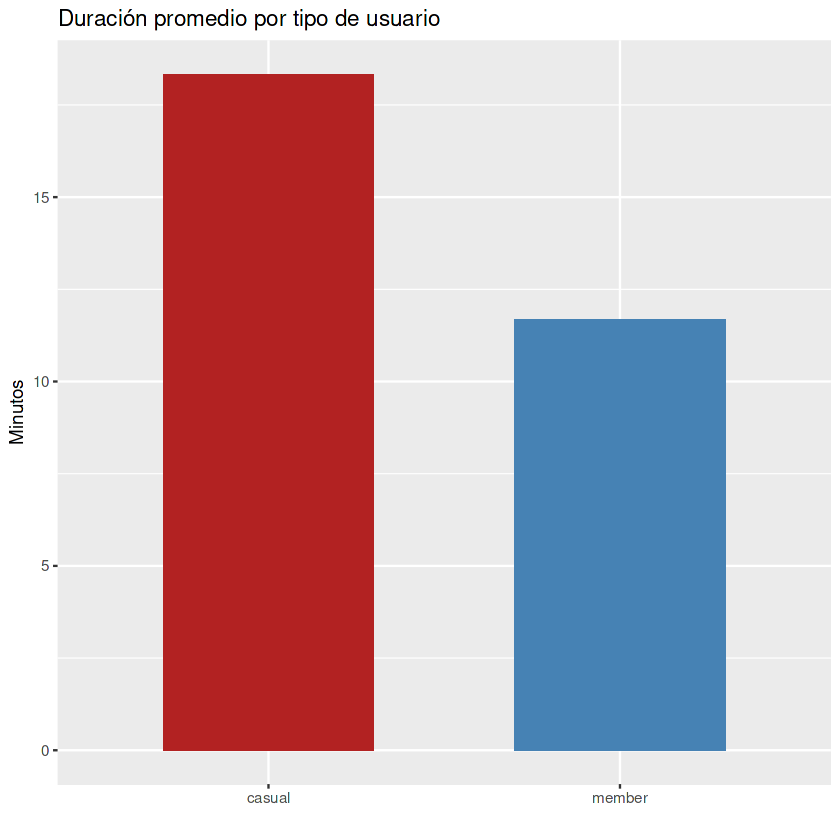

In [26]:
anualD %>%
  group_by(member_casual) %>%
  summarise(promedio = mean(duracion_minutos)) %>%
  ggplot(aes(member_casual, promedio, fill = member_casual)) +
  geom_col(width = 0.6) +
  labs(title = "Duración promedio por tipo de usuario", x = "", y = "Minutos") +
  scale_fill_manual(values = c("casual"="firebrick","member"="steelblue")) +
  theme(legend.position = "none")

Resultados:

* La media fue de 14 min y la mediana de 9.9 min.
* Los viajes suelen durar entre 6 y 17 minutos.
* Casuales → viajes más largos (media 18 min, mediana 12 min).
* Miembros → viajes más cortos y consistentes (media 11 min, mediana 8.7 min).
 
 👉 Indica que los casuales usan la bici con fines recreativos/turísticos, mientras que los miembros lo hacen en trayectos diarios.


In [30]:
# 3 Viajes por hora
viajes_hora <- anualD %>%
  group_by(member_casual, hora_inicio) %>%
  summarise(conteo = n(), .groups = "drop")

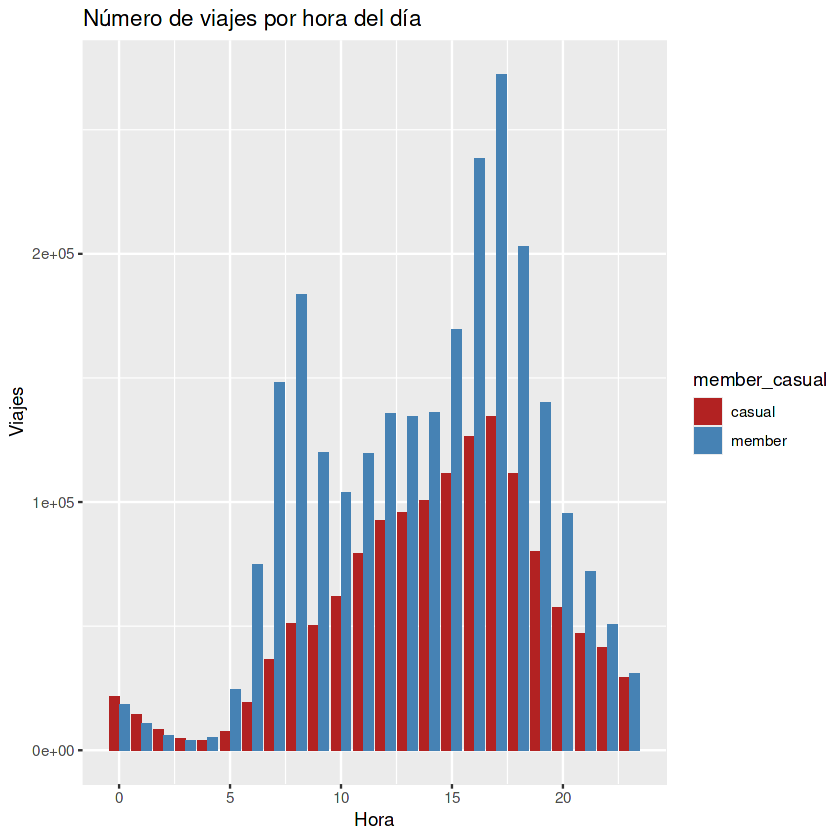

In [31]:
#Graficamos los resultados

ggplot(viajes_hora, aes(hora_inicio, conteo, fill = member_casual)) +
  geom_col(position = "dodge") +
  labs(title="Número de viajes por hora del día", x="Hora", y="Viajes") +
  scale_fill_manual(values = c("casual"="firebrick","member"="steelblue"))

Los miembros concentran viajes en horas laborales: 7–9h y 16–19h.

Casuales muestran actividad más dispersa, incluso de madrugada, con viajes más largos (17–20 min en horas centrales del día).
 👉 Confirma el patrón de transporte laboral vs ocio.


In [32]:
# 4 Viajes por día de la semana
viajes_dia <- anualD %>%
  group_by(member_casual, dia_semana) %>%
  summarise(conteo = n(), .groups = "drop")

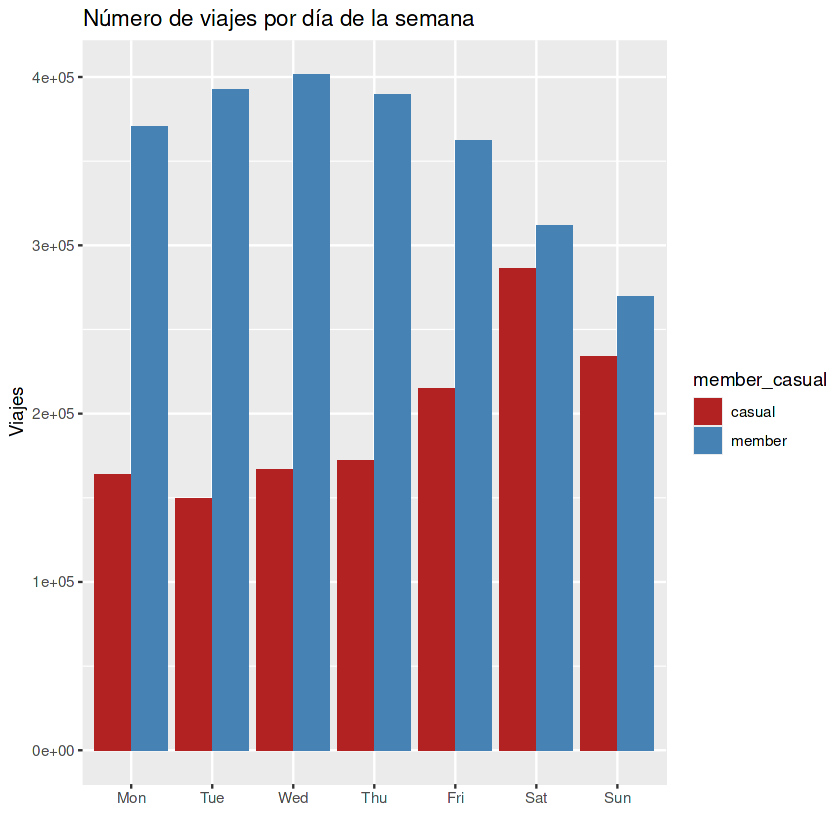

In [33]:
ggplot(viajes_dia, aes(dia_semana, conteo, fill = member_casual)) +
  geom_col(position = "dodge") +
  labs(title="Número de viajes por día de la semana", x="", y="Viajes") +
  scale_fill_manual(values = c("casual"="firebrick","member"="steelblue"))

Casuales → fuertes los fines de semana, sobre todo sábados.
Miembros → uso elevado y constante de lunes a viernes, que se mantiene también en fines de semana.

Esto refuerza la diferencia entre un segmento recreativo y otro cotidiano.


In [34]:
# 5 Viajes por mes
viajes_mes <- anualD %>%
  group_by(member_casual, mes) %>%
  summarise(conteo = n(), .groups = "drop")

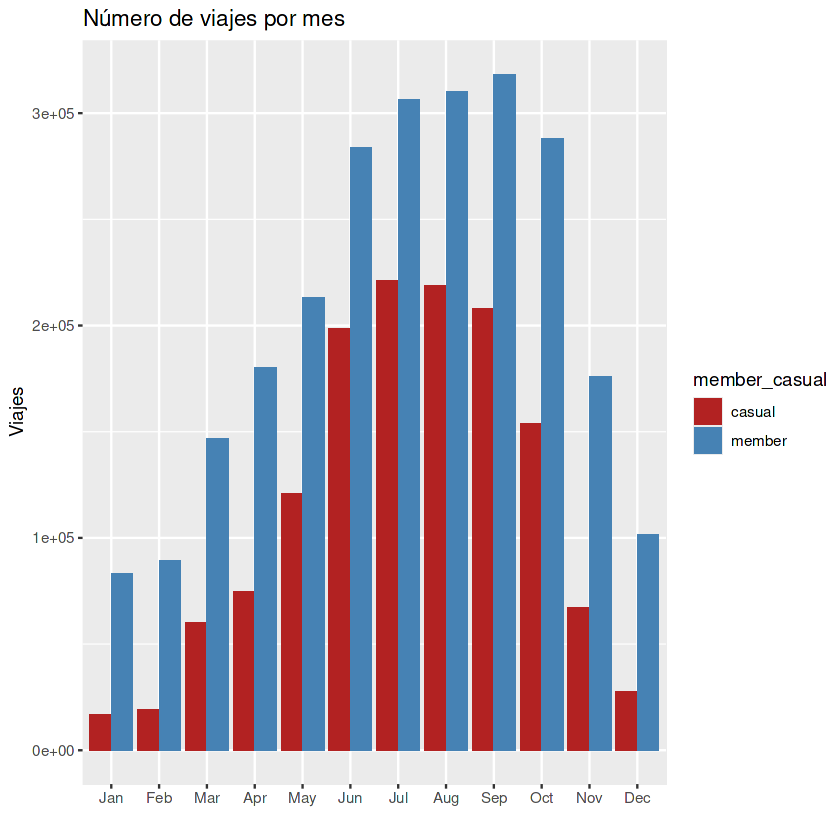

In [35]:
ggplot(viajes_mes, aes(mes, conteo, fill = member_casual)) +
  geom_col(position = "dodge") +
  labs(title="Número de viajes por mes", x="", y="Viajes") +
  scale_fill_manual(values = c("casual"="firebrick","member"="steelblue"))

Casuales → comportamiento altamente estacional, con picos en verano (mayo–septiembre) y caídas en invierno.

Miembros → uso estable todo el año, aunque también con mayor actividad en verano.

Evidencia que los casuales dependen más de la temporada, mientras que los miembros son un flujo constante de ingresos.
